In [1]:
'''
given a lot of the data is messed up. i am trying to re-do them
'''

'\ngiven a lot of the data is messed up. i am trying to re-do them\n'

In [19]:
import os


import pandas as pd
import numpy as np

In [21]:
t7 = '/media/ak/T7'
bars = ['tick', 'volume', 'calendar', 'dollar']
rawDataFolder = os.path.join(t7, 'FuturesDataSemiProcessed')
symbol = 'YM1'  # replace with your symbol

In [25]:
symbol_raw_data_path = os.path.join(rawDataFolder, symbol)
raw_files = os.listdir(symbol_raw_data_path)


In [94]:
fileIdx =15
fileLoc = os.path.join(symbol_raw_data_path, raw_files[fileIdx])
dateKey = raw_files[fileIdx].split('.')[0]

In [96]:
df = pd.read_pickle(fileLoc)[dateKey]
df.keys()

dict_keys(['tick', 'volume', 'calendar', 'dollar'])

In [97]:
tick = df['tick']
calendar = df['calendar']
volume = df['volume']
dollar = df['dollar']


In [98]:
dollar.columns.values

array(['BidSize_open', 'BidSize_high', 'BidSize_low', 'BidSize_close',
       'QuoteTime_open', 'QuoteTime_high', 'QuoteTime_low',
       'QuoteTime_close', 'type_x_open', 'type_x_high', 'type_x_low',
       'type_x_close', 'BestBid_open', 'BestBid_high', 'BestBid_low',
       'BestBid_close', 'TradeTime_open', 'TradeTime_high',
       'TradeTime_low', 'TradeTime_close', 'AskSize_open', 'AskSize_high',
       'AskSize_low', 'AskSize_close', 'BestAsk_open', 'BestAsk_high',
       'BestAsk_low', 'BestAsk_close', 'TradeSize_open', 'TradeSize_high',
       'TradeSize_low', 'TradeSize_close', 'type_open', 'type_high',
       'type_low', 'type_close', 'TradePrice_open', 'TradePrice_high',
       'TradePrice_low', 'TradePrice_close', 'TimeStamp_open',
       'TimeStamp_high', 'TimeStamp_low', 'TimeStamp_close',
       'TradeVolume_open', 'TradeVolume_high', 'TradeVolume_low',
       'TradeVolume_close', 'total_traded_volume_open',
       'total_traded_volume_high', 'total_traded_volume_low',


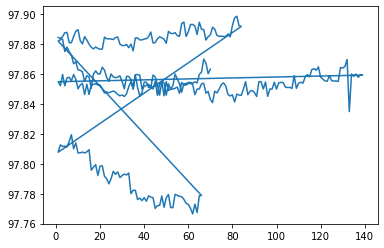

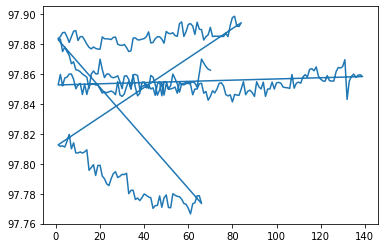

In [102]:
import matplotlib.pyplot as plt
dataframe = tick
plt.plot(dataframe['micro_price_open'])
plt.show()
plt.plot(dataframe['micro_price_close'])
plt.show()

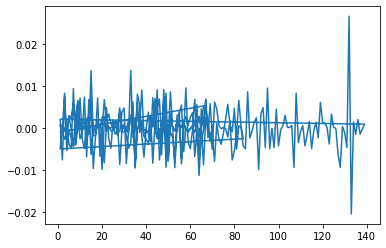

In [103]:
plt.plot(dataframe['micro_price_open'] - dataframe['micro_price_close'])

In [104]:
def parkinson(df, clean=True):
    # Convert QuoteTime columns to datetime, if they are not already
    df['QuoteTime_open'] = pd.to_datetime(df['QuoteTime_open'])
    df['QuoteTime_close'] = pd.to_datetime(df['QuoteTime_close'])

    # Calculate time difference in seconds, then convert to trading days
    df['period'] = (df['QuoteTime_close'] - df['QuoteTime_open']).dt.total_seconds() / (24 * 60 * 60)
    
    # Compute the raw measure
    rs = (1.0 / (4.0 * np.log(2.0))) * (df['micro_price_high'] / df['micro_price_close']).apply(np.log) ** 2.0

    # Divide each rs by its corresponding period
    rs = rs / df['period']

    # The Parkinson's number for each row is the square root of rs, annualized
    parkinson_volatility = np.sqrt(rs * 252)*100

    if clean:
        # Remove any rows with NaN values
        parkinson_volatility = parkinson_volatility.dropna()

    return parkinson_volatility


In [105]:
def garman_klass(df, clean=True):
    # Convert QuoteTime columns to datetime, if they are not already
    df['QuoteTime_open'] = pd.to_datetime(df['QuoteTime_open'])
    df['QuoteTime_close'] = pd.to_datetime(df['QuoteTime_close'])

    # Calculate time difference in seconds, then convert to trading days
    df['period'] = (df['QuoteTime_close'] - df['QuoteTime_open']).dt.total_seconds() / (24 * 60 * 60)

    # Calculate the Garman-Klass volatility for each row
    log_hl = (df['micro_price_high'] / df['micro_price_low']).apply(np.log)
    log_cc = (df['micro_price_close'] / df['micro_price_open']).apply(np.log)
    rs = 0.5 * log_hl**2 - (2*np.log(2) - 1) * log_cc**2

    # Divide each rs by its corresponding period
    rs = rs / df['period']

    # The Garman-Klass volatility for each row is the square root of rs, annualized
    garman_klass_volatility = np.sqrt(rs * 252)*100

    if clean:
        # Remove any rows with NaN values
        garman_klass_volatility = garman_klass_volatility.dropna()

    return garman_klass_volatility


In [79]:
import numpy as np
import pandas as pd
from scipy.special import gamma

class VolatilityMetrics:
    def __init__(self):
        self.mu_1 = np.sqrt(2 / np.pi)
        self.mu_43 = 2 ** (2 / 3) * gamma(7 / 6) / np.sqrt(gamma(1 / 2))

    def parkinson(self, df, clean=True):
        df['period'] = (pd.to_datetime(df['QuoteTime_close']) - pd.to_datetime(df['QuoteTime_open'])).dt.total_seconds() / (24 * 60 * 60)
        rs = (1.0 / (4.0 * np.log(2.0))) * (df['micro_price_high'] / df['micro_price_close']).apply(np.log) ** 2.0
        df['parkinson_vol'] = np.sqrt(df['period'] * rs)
        if clean:
            df = df.dropna()
        return df

    def garman_klass(self, df, clean=True):
        df['period'] = (pd.to_datetime(df['QuoteTime_close']) - pd.to_datetime(df['QuoteTime_open'])).dt.total_seconds() / (24 * 60 * 60)
        df['log_hl'] = (df['micro_price_high'] / df['micro_price_low']).apply(np.log)
        df['log_cc'] = (df['micro_price_close'] / df['micro_price_open']).apply(np.log)
        df['garman_klass_vol'] = np.sqrt(0.5 * df['log_hl']**2 - (2*np.log(2) - 1) * df['log_cc']**2) / np.sqrt(df['period'])
        if clean:
            df = df.dropna()
        return df

    def bipower_variation(self, df, rollingWindow=5, clean=True):
        log_hl = (df['micro_price_high'] / df['micro_price_low']).apply(np.log)
        bv = self.mu_1 ** (-2) * (log_hl.abs() * log_hl.shift(1).abs()).fillna(0).rolling(rollingWindow).sum()

        if clean:
            bv = bv.dropna()

        return bv

    def tripower_quarticity(self, df, rollingWindow=5, clean=True):
        log_hl = (df['micro_price_high'] / df['micro_price_low']).apply(np.log)
        tpq = self.mu_43 ** (-3) * ((log_hl.abs() ** (4 / 3) * log_hl.shift(1).abs() ** (4 / 3) * log_hl.shift(2).abs() ** (4 / 3)).rolling(rollingWindow).sum().fillna(0))

        if clean:
            tpq = tpq.dropna()

        return tpq

    @staticmethod
    def rectangular_kernel(h, H):
        """
        Rectangular Kernel Function for weight calculation
        :param h: specific lag
        :param H: maximum lag
        :return: weight for specific lag h
        """
        return 1.0 if abs(h) <= H else 0.0

    @staticmethod
    def bartlett_kernel(h, H):
        """
        Bartlett Kernel Function for weight calculation
        :param h: specific lag
        :param H: maximum lag
        :return: weight for specific lag h
        """
        return 1.0 - abs(h) / (H + 1)

    @staticmethod
    def epanechnikov_kernel(h, H):
        """
        Epanechnikov Kernel Function for weight calculation
        :param h: specific lag
        :param H: maximum lag
        :return: weight for specific lag h
        """
        return 0.75 * (1 - (h / (H + 1))**2) if abs(h) <= H else 0.0

    def realized_kernel(self, df, H, kernel='bartlett', clean=True):
        """
        Realized Kernel estimator
        :param df: input DataFrame
        :param H: bandwidth parameter, maximum lag in kernel weight calculation
        :param kernel: kernel type for weight calculation
        :param clean: if True, remove rows with NaN values
        :return: realized kernel volatility
        """
        df['log_return'] = np.log(df['micro_price_close']) - np.log(df['micro_price_close'].shift(1))
        df['log_return'].fillna(0, inplace=True)
        n = len(df)
        
        gamma_h = np.zeros(2 * H + 1)

        for h in range(-H, H + 1):
            gamma_h[h + H] = np.sum(df['log_return'].iloc[H:n-H].values * df['log_return'].shift(h).iloc[H:n-H].values)

        if kernel.lower() == 'bartlett':
            kernel_weights = np.array([self.bartlett_kernel(h, H) for h in range(-H, H + 1)])
        elif kernel.lower() == 'rectangular':
            kernel_weights = np.array([self.rectangular_kernel(h, H) for h in range(-H, H + 1)])
        elif kernel.lower() == 'epanechnikov':
            kernel_weights = np.array([self.epanechnikov_kernel(h, H) for h in range(-H, H + 1)])
        else:
            raise ValueError("Invalid kernel. Choose from ['bartlett', 'rectangular', 'epanechnikov']")

        df['realized_kernel'] = np.dot(gamma_h, kernel_weights)

        if clean:
            df = df.dropna()

        return df.realized_kernel



In [107]:
metrics = VolatilityMetrics()



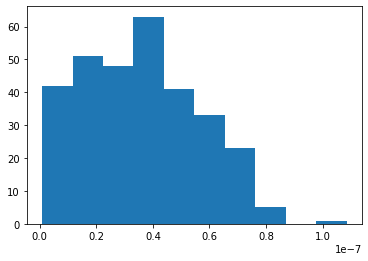

In [112]:
_=plt.hist(metrics.bipower_variation(dataframe))

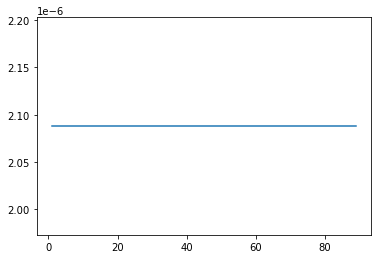

In [85]:
plt.plot(df_realized_kernel.realized_kernel)